I restructure a bit of the code here and also some of the data. The researchers have not been consistent in the enumeration of the peptides neither the domains so its kinda difficult to structure it all together. 

**UPDATE**:

There was lots of redundant code that I had written for demonstration purposes. The code written henceforth is cleaner and more modular(I hope) 

In [1]:
import os 
os.chdir('E:\Ecole\Year 3\Projet 3A')
import pandas as pd
import numpy as np 

class Domain:
    
    def __init__(self, name):
        self.name = name
        self.thresholds = None
        self.thetas = None

class Peptide:
    
    def __init__(self, name):
        self.name = name
        self.sequence = None
        self.sequence_bis = None ##Sequence bis are the last five amino acids
        self.energy_ground = 0.0 ##Anticipating the calculation of a ground state energy for the peptide
        
class Data:
    
    def __init__(self):
        temp_df = pd.read_excel('Data_PDZ/MDSM_01_stiffler_bis.xls')
        self.aminoacids = [acid.encode('utf-8') for acid in list(temp_df.columns[:20])]
        self.df = temp_df.T
        self.domains = [Domain(domain.encode('utf-8')) for domain in list(self.df.columns)]
        self.domain_names = [domain.name for domain in self.domains]
        self.pep_seqs = []
        self.pep_names = []
        with open('Data_PDZ/peptides.free') as f:
            for line in f:
                x = line.split()
                self.pep_seqs.append(x[1])
                self.pep_names.append(x[0])
        self.peptides = [Peptide(name) for name in self.pep_names]
        
    def create_domains(self):
        for domain in self.domains:
            domain.thetas = self.df[domain.name][:100]
            domain.thetas = np.asarray(domain.thetas)
            domain.thetas = domain.thetas.reshape(5,20)
            domain.thresholds = np.asarray(self.df[domain.name][100:])   
    
    def create_peptides(self):
        for i in range(len(self.pep_seqs)):
            self.peptides[i].sequence = self.pep_seqs[i]
            self.peptides[i].sequence_bis = list(self.pep_seqs[i])[5:]        

In [2]:
PDZ_Data = Data()
PDZ_Data.create_domains()
PDZ_Data.create_peptides()

Now we have created the preliminary data with the binding energy values and the peptide sequences. The last thing left to do is to get the data from the interaction matrix for each of the domain. 

We also write some convenience functions like the log and sigmoid functions 

In [3]:
fp_interaction_matrix = pd.read_excel('Data_PDZ/fp_interaction_matrix.xlsx')
for column in fp_interaction_matrix.columns:
    fp_interaction_matrix.loc[fp_interaction_matrix[column] == 0.0, column] = -1.0
fp_interaction_matrix = fp_interaction_matrix.rename(columns=lambda x: str(x).replace(" ", ""))

In [4]:
## Sigmoid Function
def sigmoid(x, a=1):
    return 1.0/(1+np.exp(-1.0*a*x))
## Log(1+exp(-x)) 
## We take care of numerical stability for values of x < 0
def log_modified(x):
    if x > 0:
        return np.log(1+np.exp(-x))
    else:
        return -x + np.log(1+np.exp(x))
    
## Convenience functions to convert between letter sequences and indexed sequences. 
## The index for each amino acid is computed using the enumeration presented in the file "MDSM_01_stiffler_bis.xls" 
def convert2seq(seq_int):
    return [PDZ_Data.aminoacids[i] for i in seq_int]
def convert2int(seq_pep):
    return [PDZ_Data.aminoacids.index(pep) for pep in seq_pep]

In [5]:
## Unlike the previous code, where we had two different versions of evaluate_score function, here we have just one. 
## To enter the sequence of a known peptide use convert2int(peptide name) 
def eval_score(domain, sequence):
    score = 0.0
    for i in range(5):
        score += domain.thetas[i,sequence[i]]
    return score - domain.thresholds[0]

In [6]:
## Similarly for the energy evaluation we simply use the single version which use the sequence directly 
## The sequence argument will be useful when making mutations starting from the basic peptide sequence 
def eval_energy(peptide, sequence, verbose=0):
    score_natural = 0.0
    energies = []
    for i in range(len(PDZ_Data.domain_names)): 
        temp = eval_score(PDZ_Data.domains[i], sequence)
        alpha = fp_interaction_matrix[peptide.name][i]
        if alpha > 0:
            alpha = +1.0
        score = temp*alpha
        temp2 = log_modified(score)
        energies.append({'Energy': temp2, 'alpha': alpha, 'score': temp})
        score_natural += temp2 
    if verbose == 0:
        return score_natural
    else:
        return score_natural, energies

Let us take a particular example and illustrate the use of these basic functions on them. We shall use the protein *Caspr2*

In [7]:
ix = PDZ_Data.pep_names.index('Caspr2')
print ix
pep_demo = PDZ_Data.peptides[ix]
print pep_demo.name
print pep_demo.sequence
print pep_demo.sequence_bis

4
Caspr2
IDESKKEWLI
['K', 'E', 'W', 'L', 'I']


In [8]:
print eval_energy(pep_demo, convert2int(pep_demo.sequence_bis))
score, energies = eval_energy(pep_demo, convert2int(pep_demo.sequence_bis), verbose=1)

10.2327578819


In [9]:
neg = []
pos = [] 
for i in range(len(energies)):
    if energies[i]['alpha'] == -1.0:
        neg.append({'data':energies[i], 'name': PDZ_Data.domain_names[i], 'index' : i+2})
    else:
        pos.append({'data':energies[i], 'name': PDZ_Data.domain_names[i], 'index' : i+2})
for item in pos:
    print item

{'index': 2, 'data': {'alpha': 1.0, 'Energy': 0.58841515662593658, 'score': 0.22172999999999998}, 'name': 'Cipp (03/10)'}
{'index': 8, 'data': {'alpha': 1.0, 'Energy': 0.69316718075994543, 'score': -4.0000000000262048e-05}, 'name': 'Dlgh3 (1/1)'}
{'index': 19, 'data': {'alpha': 1.0, 'Energy': 2.5693183193875501e-05, 'score': 10.569272000000002}, 'name': 'HtrA3 (1/1)'}
{'index': 33, 'data': {'alpha': 1.0, 'Energy': 0.6931021815724453, 'score': 9.0000000000145519e-05}, 'name': 'Mpp7 (1/1)'}
{'index': 43, 'data': {'alpha': 1.0, 'Energy': 0.69316718075994543, 'score': -4.0000000000262048e-05}, 'name': 'PAR-3 (3/3)'}


In [10]:
## We calculate the natural energies for each of the peptides 
for pep in PDZ_Data.peptides:
    pep.energy_ground = eval_energy(pep, convert2int(pep.sequence_bis))

In [11]:
## Sanity Check 
print PDZ_Data.peptides[ix].energy_ground

10.2327578819



## Simulation 
Now we shall start with the real Monte Carlo step. Our algorithm is based on the famous Metropolis algorithm. We start with a given peptide and its sequence. To each peptide is associated a particular energy(which we calculated above). We expect that under mutations of the sequence, this energy will change. Depending on whether the energy changes or not after a point mutation, we shall accept or reject the mutation. 

Let us first start off by writing some convenience functions to make point mutations

**UPDATE**:

After some problems with the data, mainly to do with the way the data was indexed by the researchers, we are finally in a position to retrieve something meaningful out of the data. 

For an initial run, the acceptance rule for the mutations was rather simple: If the energy reduced we would accept the mutation, otherwise not. Surprisingly, with such a rule, no new mutations which conserve the original binding pairs, are allowed. Further exploration is needed at this stage to completely deconstruct this finding.

To facilitate further analysis, I compute the energies and the scores for each of the peptide-PDZ pairs. These energies will serve as a reference for further mutations. 

To make a mutation we need two numbers, one a number between 0 and 4 which will tell us the position to be mutated and a number between 0 and 19 which will tell us the amino acid to put in that position. We can do this easily by making two calls to the randomint function in numpy. 

In [12]:
y = np.random.randint(5)
z = np.random.randint(20)
print y, z

0 2


This is a basic run where we introduce mutations and see whether the energy actually reduces or not. The base energy is 8.178291

We now run the Metropolis Hastings algorithm for our data set. If the energy decreases then it is a favorable mutation and we accept the mutation, otherwise we reject the mutation

In [15]:
test_peptide = PDZ_Data.peptides[57]
print test_peptide.name
print test_peptide.energy_ground

AcvR1
8.1782910361


In [16]:
print " Uniform {} Test {}".format(np.random.uniform(), 2)

 Uniform 0.38313776258 Test 2


In [220]:
def run_mc(nb_runs, peptide,temp = 1.0, nb_cycles=10, plot=False, verbose=True, print_reject = False):
    import matplotlib.pyplot as plt
    sims = []
    print "Name of Peptide {}".format(peptide.name)
    print "Base Energy {}".format(peptide.energy_ground)
    print "Base Sequence {}".format(peptide.sequence_bis)
    base_seq = convert2int(peptide.sequence_bis)
    for j in range (nb_cycles):
        print "\n Cycle number : {}\n".format(j+1)
        sim_results = []
        mutated_sequences = []
        mutated_energies = []
        for_plot = []
        sequences_accepted = []
        mut_seq = base_seq
        mut_energy = peptide.energy_ground
        for i in range(nb_runs):
            y = np.random.randint(5)
            z = np.random.randint(19)
            ## Remove if the amino acid change is the same as before 
            if z >= mut_seq[y]:
                z = z+1                
            temp_seq = mut_seq[:]
            #print "Last sequence seen {}".format(convert2seq(mut_seq))
            temp_seq[y] = z
            #print "Sequence after mutation {}\n".format(convert2seq(temp_seq))
            temp_energy = eval_energy(peptide, temp_seq)
            ratio = np.exp(-temp*(temp_energy-mut_energy))
            prob_trans = min(1, ratio)
            x = np.random.uniform()
            if x < prob_trans:
                mut_energy = temp_energy
                mut_seq = temp_seq
                if verbose:
                    print "Run number: {}\n".format(i)
                    print "Uniform {} Ratio {} Prob_Trans {} ".format(x,ratio,prob_trans)
                    print "Accepted {} {} {} {} \n".format(temp_seq, temp_energy, convert2seq(temp_seq), convert2seq(mut_seq))
                sim_results.append({'Sequence': temp_seq, 'Energy': temp_energy, 'Status': 'Accepted'})
                for_plot.append(temp_energy)
            else:
                if verbose: 
                    if print_reject:                        
                        print "Run number: {}\n".format(i)
                        print "Uniform {} Ratio {} Prob_Trans {} ".format(x,ratio,prob_trans)
                        print "Rejected {} {} {} {}\n".format(temp_seq, temp_energy, convert2seq(temp_seq), convert2seq(mut_seq))
                sim_results.append({'Sequence': temp_seq, 'Energy': temp_energy, 'Status': 'Rejected'})  

                ##print "Rejected {} {}".format(temp_seq, temp_energy)
            mutated_sequences.append(temp_seq)
            mutated_energies.append(temp_energy)
        print "Lowest Energy {} Sequence {}\n".format(np.min(mutated_energies), convert2seq(mutated_sequences[np.argmin(mutated_energies)]))
        if plot == True:
            plt.figure(j)            
            plt.axhline(y = peptide.energy_ground, hold = None, c = 'r', linewidth=0.5)
            if len(for_plot) == 1:
                plt.axhline(y = for_plot[0], hold=None, c = 'b', linewidth = 1.5)
            plt.plot(for_plot)
            plt.show()
        sims.append({'Results' : sim_results, 'Mutated sequences': mutated_sequences, 'Mutated Energies': mutated_energies}) 

    return sims

Here we perform mutations for the given peptide and only accept those mutations which lead to a reduction in the energy. Here the inverse temperature $\beta$ is infinite (or $T=0$)

**UPDATE**: 

Infact the only problem that I needed to do was to make a copy as such 

    temp_seq = orig_seq[:] 
    

1. I had to modify the code for the modification of the temporary lists. 

2. What follows is a verification that when I do make a mutation, and the mutation is not a valid one, we shall conserve the last sequence which was accepted. 


## Things to do 

1. Compute statistics for the various peptides. The interesting values to consider would be the distribution of energies for a given peptide. 

2. Another interesting question to consider would be the number of distinct mutations that are possible for any given peptide. 

3. Finally, we could look at whether, after mutations, the sequences are different or not from the natural sequence of some other peptide. 

## After correction 

We shall first see that if the sequence is not accepted, we stick with the sequence accepted last. We take a very small run size and verify this.

Name of Peptide AcvR1
Base Energy 8.1782910361
Base Sequence ['L', 'K', 'T', 'D', 'C']

 Cycle number : 1

Run number: 0

Uniform 0.767897901087 Ratio 3.75318931595 Prob_Trans 1 
Accepted [12, 15, 10, 18, 14] 6.85568507332 ['Q', 'K', 'T', 'D', 'C'] ['Q', 'K', 'T', 'D', 'C'] 

Run number: 1

Uniform 0.614581194775 Ratio 5.70121275706e-13 Prob_Trans 5.70121275706e-13 
Rejected [12, 15, 10, 18, 4] 35.0486123656 ['Q', 'K', 'T', 'D', 'I'] ['Q', 'K', 'T', 'D', 'C']

Run number: 2

Uniform 0.14430032615 Ratio 51.8439314288 Prob_Trans 1 
Accepted [12, 15, 14, 18, 14] 2.90744718641 ['Q', 'K', 'C', 'D', 'C'] ['Q', 'K', 'C', 'D', 'C'] 

Run number: 3

Uniform 0.198185700284 Ratio 2.53796322172 Prob_Trans 1 
Accepted [12, 11, 14, 18, 14] 1.97608530827 ['Q', 'N', 'C', 'D', 'C'] ['Q', 'N', 'C', 'D', 'C'] 

Run number: 4

Uniform 0.284006067268 Ratio 0.872241486648 Prob_Trans 0.872241486648 
Accepted [12, 14, 14, 18, 14] 2.11277426745 ['Q', 'C', 'C', 'D', 'C'] ['Q', 'C', 'C', 'D', 'C'] 

Run number: 

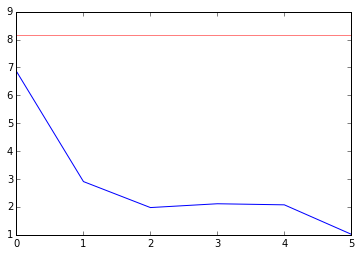

In [296]:
results = run_mc(10, test_peptide, nb_cycles = 1, plot = True, verbose=True, print_reject=True)

Let us now consider a peptide which according to the FP Interaction Matrix binds to a lot many domains and see how its behavior is different from that of the peptide *AcvR1*. For the next demo, we shall consider *Cnksr2*

In [225]:
test_peptide2 = PDZ_Data.peptides[PDZ_Data.pep_names.index('Cnksr2')]
print test_peptide2.name
print test_peptide2.energy_ground
print test_peptide2.sequence_bis

Cnksr2
6.91618770844
['I', 'E', 'T', 'H', 'V']


Name of Peptide Cnksr2
Base Energy 6.91618770844
Base Sequence ['I', 'E', 'T', 'H', 'V']

 Cycle number : 1

Run number: 32

Uniform 0.00856654446079 Ratio 0.0190867525859 Prob_Trans 0.0190867525859 
Accepted [4, 19, 10, 17, 6] 10.8749484749 ['I', 'E', 'T', 'H', 'P'] ['I', 'E', 'T', 'H', 'P'] 

Run number: 41

Uniform 0.143320068804 Ratio 0.727386922577 Prob_Trans 0.727386922577 
Accepted [4, 19, 10, 17, 1] 11.1932451998 ['I', 'E', 'T', 'H', 'A'] ['I', 'E', 'T', 'H', 'A'] 

Run number: 48

Uniform 0.141218061373 Ratio 0.330192385245 Prob_Trans 0.330192385245 
Accepted [4, 19, 10, 17, 4] 12.3013250086 ['I', 'E', 'T', 'H', 'I'] ['I', 'E', 'T', 'H', 'I'] 

Run number: 49

Uniform 0.349952916591 Ratio 4.16358521525 Prob_Trans 1 
Accepted [4, 19, 10, 17, 6] 10.8749484749 ['I', 'E', 'T', 'H', 'P'] ['I', 'E', 'T', 'H', 'P'] 

Run number: 91

Uniform 0.0754151912447 Ratio 0.139546351988 Prob_Trans 0.139546351988 
Accepted [4, 19, 10, 17, 13] 12.8443069355 ['I', 'E', 'T', 'H', 'Y'] ['I', 'E', '

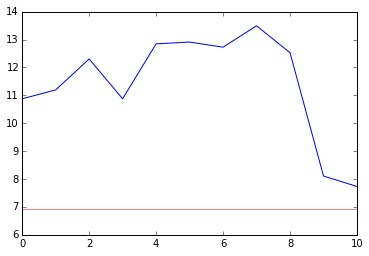

In [301]:
results_2  = run_mc(200, test_peptide2, nb_cycles = 1, plot = True, verbose=True, print_reject=False)

Name of Peptide Cnksr2
Base Energy 6.91618770844
Base Sequence ['I', 'E', 'T', 'H', 'V']

 Cycle number : 1

Lowest Energy 6.60122455223 Sequence ['L', 'E', 'T', 'H', 'V']



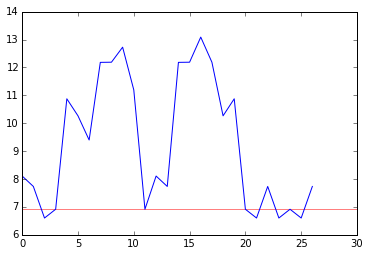


 Cycle number : 2

Lowest Energy 6.60122455223 Sequence ['L', 'E', 'T', 'H', 'V']



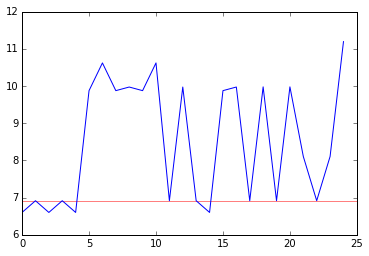


 Cycle number : 3

Lowest Energy 6.60122455223 Sequence ['L', 'E', 'T', 'H', 'V']



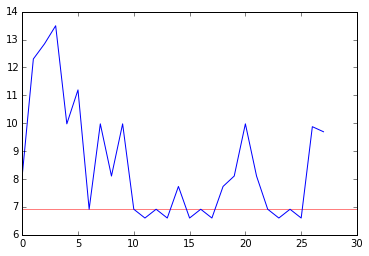


 Cycle number : 4

Lowest Energy 6.60122455223 Sequence ['L', 'E', 'T', 'H', 'V']



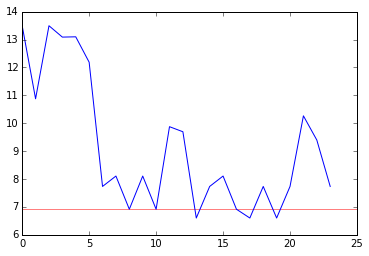


 Cycle number : 5

Lowest Energy 6.60122455223 Sequence ['L', 'E', 'T', 'H', 'V']



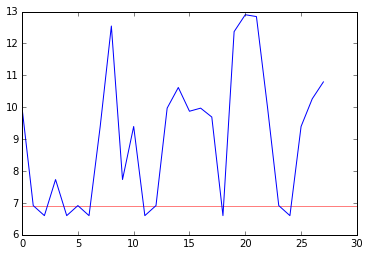


 Cycle number : 6

Lowest Energy 6.60122455223 Sequence ['L', 'E', 'T', 'H', 'V']



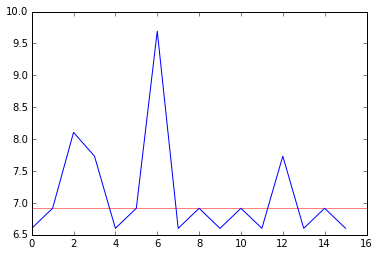


 Cycle number : 7

Lowest Energy 6.60122455223 Sequence ['L', 'E', 'T', 'H', 'V']



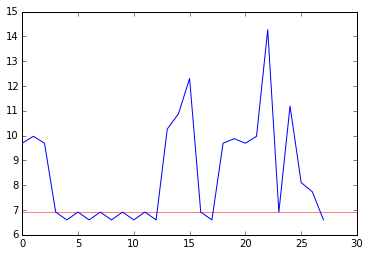


 Cycle number : 8

Lowest Energy 6.60122455223 Sequence ['L', 'E', 'T', 'H', 'V']



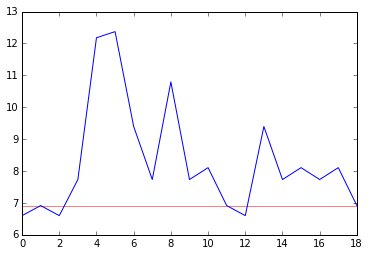


 Cycle number : 9

Lowest Energy 6.60122455223 Sequence ['L', 'E', 'T', 'H', 'V']



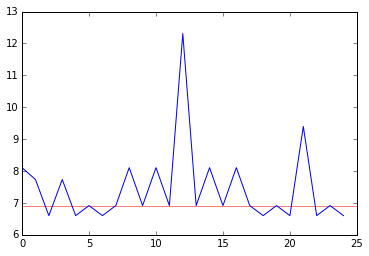


 Cycle number : 10

Lowest Energy 6.60122455223 Sequence ['L', 'E', 'T', 'H', 'V']



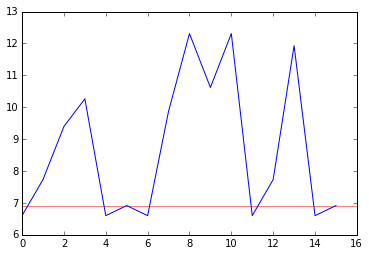

In [302]:
results_4 = run_mc(1000, test_peptide2, nb_cycles = 10, plot = True, verbose=False, print_reject=False)

In [43]:
test_peptide3 = PDZ_Data.peptides[7]
print test_peptide3.name
print test_peptide3.energy_ground
print test_peptide3.sequence_bis

c-KIT
1.75989867909
['V', 'H', 'E', 'D', 'A']


Name of Peptide c-KIT
Base Energy 1.75989867909
Base Sequence ['V', 'H', 'E', 'D', 'A']

 Cycle number : 1

Lowest Energy 1.04650609224 Sequence ['R', 'P', 'C', 'D', 'A']



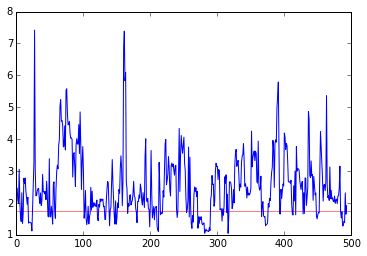


 Cycle number : 2

Lowest Energy 0.829067561681 Sequence ['K', 'G', 'R', 'D', 'M']



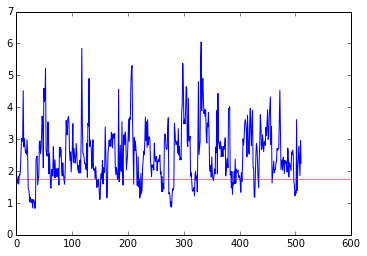


 Cycle number : 3

Lowest Energy 0.982797053337 Sequence ['K', 'E', 'K', 'N', 'Q']



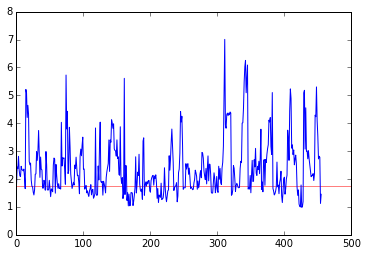


 Cycle number : 4

Lowest Energy 0.931675963881 Sequence ['A', 'E', 'A', 'N', 'E']



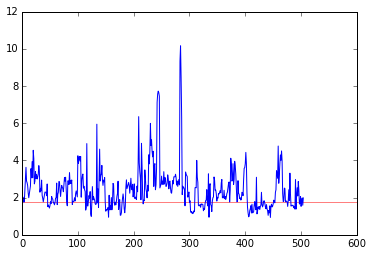


 Cycle number : 5

Lowest Energy 0.874240043071 Sequence ['K', 'D', 'P', 'D', 'P']



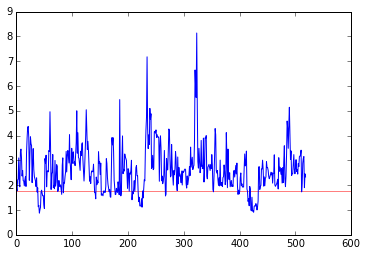


 Cycle number : 6

Lowest Energy 0.821642467699 Sequence ['A', 'E', 'A', 'N', 'Y']



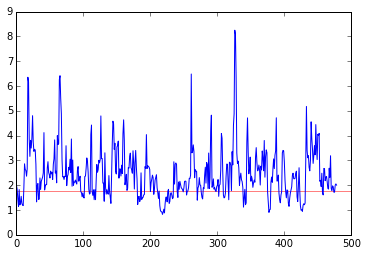


 Cycle number : 7

Lowest Energy 1.07304794941 Sequence ['H', 'E', 'P', 'C', 'M']



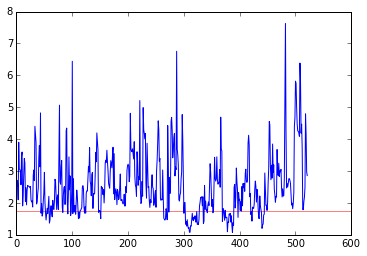


 Cycle number : 8

Lowest Energy 0.968598839211 Sequence ['K', 'E', 'R', 'N', 'T']



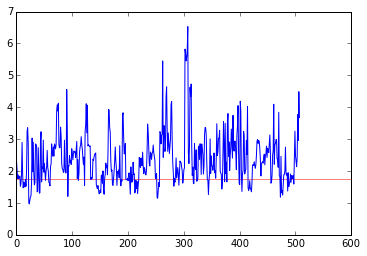


 Cycle number : 9

Lowest Energy 0.932132425351 Sequence ['H', 'E', 'G', 'C', 'M']



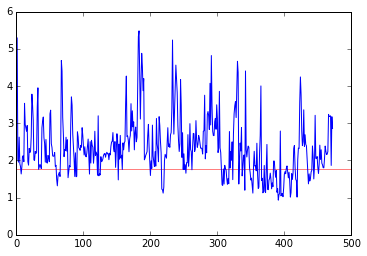


 Cycle number : 10

Lowest Energy 0.898958680239 Sequence ['K', 'P', 'C', 'D', 'M']



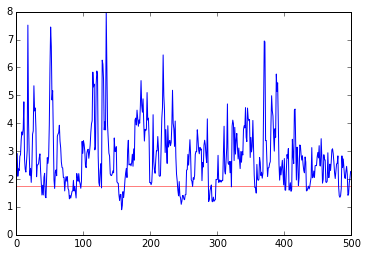

In [303]:
results5 = run_mc(1000, test_peptide3, nb_cycles = 10, plot = True, verbose=False, print_reject=True)

## Interesting Case 

During the previous runs, I had noticed that Cftr was a remarkable peptide because it didnt admit too many mutations. Of course, I couldnt have used the previous data because of the bug. Let us see, how it actually behaves given that the code is free of bugs

We shall notice that it admits just a single mutation, slightly more energetic than the base sequence and no others. The evolution of the sequences is shown as well. 
 

Cftr
Name of Peptide Cftr
Base Energy 10.1187576025
Base Sequence ['Q', 'E', 'T', 'R', 'L']

 Cycle number : 1

Run number: 316

Uniform 0.27514608764 Ratio 0.436413450944 Prob_Trans 0.436413450944 
Accepted [12, 19, 10, 16, 4] 10.9479228055 ['Q', 'E', 'T', 'R', 'I'] ['Q', 'E', 'T', 'R', 'I'] 

Run number: 475

Uniform 0.0594456303977 Ratio 2.2914050835 Prob_Trans 1 
Accepted [12, 19, 10, 16, 3] 10.1187576025 ['Q', 'E', 'T', 'R', 'L'] ['Q', 'E', 'T', 'R', 'L'] 

Run number: 744

Uniform 0.427272477207 Ratio 0.436413450944 Prob_Trans 0.436413450944 
Accepted [12, 19, 10, 16, 4] 10.9479228055 ['Q', 'E', 'T', 'R', 'I'] ['Q', 'E', 'T', 'R', 'I'] 

Run number: 870

Uniform 0.209330963498 Ratio 2.2914050835 Prob_Trans 1 
Accepted [12, 19, 10, 16, 3] 10.1187576025 ['Q', 'E', 'T', 'R', 'L'] ['Q', 'E', 'T', 'R', 'L'] 

Run number: 930

Uniform 0.15221517281 Ratio 0.436413450944 Prob_Trans 0.436413450944 
Accepted [12, 19, 10, 16, 4] 10.9479228055 ['Q', 'E', 'T', 'R', 'I'] ['Q', 'E', 'T', 'R', '

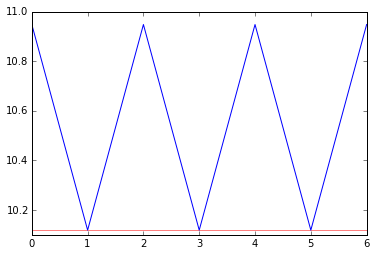

In [313]:
test_peptide4 = PDZ_Data.peptides[6]
print test_peptide4.name
results = run_mc(1000, test_peptide4, nb_cycles = 1, plot = True, verbose=True, print_reject=False)

We realise that, in stark contrast to the previous cases, Cftr doesn't allow too much variation in its sequence. 

**Question**: How do we go about exploring this difference among peptides? We could start by looking at the number of distinct sequences that are allowed.

# DATA ANALYSIS 

Consider a given peptide and let us perform mutations on this peptide. We shall consider 1000 mutations in any one cycle and conserve only those energies which the mutation was accepted. So lets begin!


In [325]:
pep_for_da = PDZ_Data.peptides[45]
print pep_for_da.name
print pep_for_da.sequence_bis
print pep_for_da.energy_ground

PIX
['D', 'E', 'T', 'N', 'L']
27.0731044414


This seems to be a good choice since it has a high base energy and thus we can expect the energy to reduce when we introduce mutations. Before we launch a full run, let us see what happens for a small run of 100 mutations. 

Name of Peptide PIX
Base Energy 27.0731044414
Base Sequence ['D', 'E', 'T', 'N', 'L']

 Cycle number : 1

Run number: 1

Uniform 0.191309128492 Ratio 23.1111759152 Prob_Trans 1 
Accepted [18, 19, 3, 11, 3] 23.932788135 ['D', 'E', 'L', 'N', 'L'] ['D', 'E', 'L', 'N', 'L'] 

Run number: 8

Uniform 0.383467484666 Ratio 5118.28240069 Prob_Trans 1 
Accepted [18, 19, 14, 11, 3] 15.3922139419 ['D', 'E', 'C', 'N', 'L'] ['D', 'E', 'C', 'N', 'L'] 

Run number: 17

Uniform 0.56058207582 Ratio 77.7688884879 Prob_Trans 1 
Accepted [18, 19, 1, 11, 3] 11.0384724815 ['D', 'E', 'A', 'N', 'L'] ['D', 'E', 'A', 'N', 'L'] 

Run number: 243

Uniform 0.018150088974 Ratio 6.03650878102 Prob_Trans 1 
Accepted [18, 19, 1, 9, 3] 9.2406466531 ['D', 'E', 'A', 'S', 'L'] ['D', 'E', 'A', 'S', 'L'] 

Run number: 479

Uniform 0.164107802019 Ratio 0.165658667332 Prob_Trans 0.165658667332 
Accepted [18, 19, 1, 11, 3] 11.0384724815 ['D', 'E', 'A', 'N', 'L'] ['D', 'E', 'A', 'N', 'L'] 

Run number: 481

Uniform 0.03824621050

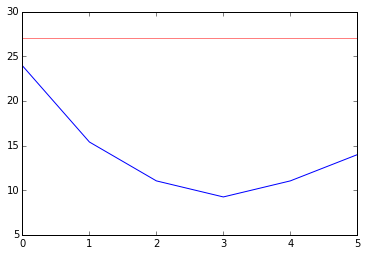

In [326]:
pep_for_da_results = run_mc(500, pep_for_da, nb_cycles=1, plot=True, verbose=True, print_reject=False)

We observe that this peptide doesn't actually admit a lot of mutations. Let us consider a larger sample space of mutations and see whether the energy goes down further or not. 

We see that after some number of steps, the sequence comes back to its original sequence. Thus it will be interesting to consider only unique sequences in further analysis. The number of such sequences will also give us an idea about how much liberty we do have when we mutate the sequences. 

In [328]:
def compute_unique(some_data):
    eners = {}
    for i in range(len(some_data)):
        data = some_data[i]['Results']
        print "Cycle Number :{}".format(i+1)
        for item in data:
            if item['Status']  == 'Accepted':
                print "Energy {} Sequence: {}".format(item['Energy'], convert2seq(item['Sequence']))
                eners[item['Energy']] = convert2seq(item['Sequence'])
    return eners
unique_seqs = compute_unique(pep_for_da_results)

Cycle Number :1
Energy 23.932788135 Sequence: ['D', 'E', 'L', 'N', 'L']
Energy 15.3922139419 Sequence: ['D', 'E', 'C', 'N', 'L']
Energy 11.0384724815 Sequence: ['D', 'E', 'A', 'N', 'L']
Energy 9.2406466531 Sequence: ['D', 'E', 'A', 'S', 'L']
Energy 11.0384724815 Sequence: ['D', 'E', 'A', 'N', 'L']
Energy 13.9751864717 Sequence: ['D', 'E', 'S', 'N', 'L']


We see that after some number of steps, the sequence comes back to its original sequence. Thus it will be interesting to consider only unique sequences in further analysis. The number of such sequences will also give us an idea about how much liberty we do have when we mutate the sequences. 

In [323]:
len(unique_seqs)

17